In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
plt.style.use('ggplot') # This styles the graphs in a nicer format

# this allows plots to appear directly in the notebook
%matplotlib inline

import statsmodels.formula.api as smf

In [31]:
UFC = pd.read_csv('Data/2a) UFC Fights.csv')

#make sure theres no space in the columns
UFC.columns = [c.replace(' ', '_') for c in UFC.columns]

#change outcome win = 1, everything else 0
UFC['OUTCOME1'] = UFC.OUTCOME.map({'win':1, 'loss':0, 'draw':0, 'NC':0})

#change stance and stance_diff into 1,0
#check out what stances there are
print UFC.STANCE.value_counts()
#lets just put orthodox as 1, other as 0
UFC['STANCE1'] = UFC.STANCE.map({'Orthodox':1, 'Southpaw':0, 'Switch':0, 'Open Stance':0,'Sideways':0})
#same stance = 0
UFC['STANCE_DIFF1'] = UFC.STANCE_DIFF.map({'Same Stance':0, 'Different Stance':1})

#Try using more stance information
# create a DataFrame with the four dummy variable columns
STANCE_dummies = pd.get_dummies(UFC.STANCE, prefix='STANCE').iloc[:, 1:]
#STANCE_dummies
UFC = pd.concat([UFC, STANCE_dummies], axis=1)

#Stance information works well, but it looksl ike southpaw is a great advantage. Group observations into southpaw = 1
#Other = 0
UFC['STANCE2'] = UFC.STANCE.map({'Orthodox':0, 'Southpaw':1, 'Switch':0, 'Open Stance':0,'Sideways':0})

#print column names and type
print UFC.dtypes
print UFC.shape

Orthodox       5338
Southpaw       1350
Switch          161
Open Stance      24
Sideways          5
Name: STANCE, dtype: int64
FIGHT_ORDER                 int64
KEY                        object
ROUND_FORMAT               object
EVENT_TYPE                 object
EVENT_NAME                 object
EVENT_YEAR                  int64
EVENT_MONTH                 int64
EVENT_DAY                   int64
LOCATION_COUNTRY           object
LOCATION_CITY              object
VENUE                      object
ATTENDANCE                float64
MAIN_FIGHT                 object
MID                         int64
WEIGHT_CLASS               object
REF                        object
METHOD                     object
METHOD_D                   object
ROUND                     float64
FINISH_ROUND_MIN          float64
FINISH_ROUND_SEC          float64
FINISH_ROUND_INSECONDS    float64
TOTAL_INSECONDS           float64
FIGHTER_NAME               object
FIGHER_NO                  object
OUTCOME                

In [32]:
#Add Business Filters
#Exclude fights where it is single round only
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')]
#see how many fights are there for each weight class
print UFC1.WEIGHT_CLASS.value_counts()
#from initial investigation we will exclude Women's classes, Catch Weight and Super Heavyweight
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')&(-UFC.WEIGHT_CLASS.isin(['Super Heavyweight','Catch Weight','Womens Bantamweight','Womens Strawweight']))&(UFC.WEIGHT_CLASS.notnull())]
print UFC1.WEIGHT_CLASS.value_counts()

Lightweight            1434
Welterweight           1400
Middleweight           1094
Light Heavyweight       726
Heavyweight             676
Featherweight           546
Bantamweight            434
Flyweight               212
Womens Bantamweight     110
Womens Strawweight       76
Catch Weight             28
Super Heavyweight         2
Name: WEIGHT_CLASS, dtype: int64
Lightweight          1434
Welterweight         1400
Middleweight         1094
Light Heavyweight     726
Heavyweight           676
Featherweight         546
Bantamweight          434
Flyweight             212
Name: WEIGHT_CLASS, dtype: int64


FIGHT_ORDER                  0
KEY                          0
ROUND_FORMAT                 0
EVENT_TYPE                   0
EVENT_NAME                   0
EVENT_YEAR                   0
EVENT_MONTH                  0
EVENT_DAY                    0
LOCATION_COUNTRY             0
LOCATION_CITY                0
VENUE                        0
ATTENDANCE                 280
MAIN_FIGHT                   0
MID                          0
WEIGHT_CLASS                 0
REF                        618
METHOD                       0
METHOD_D                    22
ROUND                        0
FINISH_ROUND_MIN             0
FINISH_ROUND_SEC             0
FINISH_ROUND_INSECONDS       0
TOTAL_INSECONDS              0
FIGHTER_NAME                 0
FIGHER_NO                    0
OUTCOME                      0
FIGHTER_ID                   0
STR                          0
TD                           0
SUB                          0
                          ... 
REACH_INCH1                 23
STANCE  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             REACH_INCH   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 1.678e+04
Date:                Sun, 15 May 2016   Prob (F-statistic):               0.00
Time:                        10:17:37   Log-Likelihood:                -11945.
No. Observations:                5880   AIC:                         2.389e+04
Df Residuals:                    5878   BIC:                         2.391e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4766      0.550      2.683      0.007         0.398     2.555
HEIGHT_CM      0.3957      0.003    129.555      0.000         0.390     0.402
==============================================================================
Omnibus:                       73.880   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.517
Skew:                           0.260   Prob(JB):                     1.47e-17
Kurtosis:                       3.213   Cond. No.                     4.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

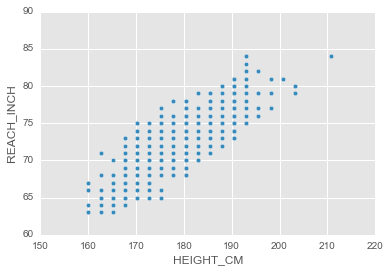

In [35]:
#check out missing values
print UFC1.isnull().sum()

#we'll need to see if we want to fill the missing values or just exclude them
#Lets see how much data we exclude by class if we exclude all observations with any missing values
UFC1a = UFC1.dropna()
print UFC1.shape
print UFC1a.shape

#roughly we've dropped half the observations - let's check by weight class but first..
#check if nickname means anything, otherwise let's drop as it makes up most of the missing
UFC1.NICK.isnull().sum()
#print UFC1[(UFC1.NICK.isnull())&(UFC1.OUTCOME=='win')].shape
#print UFC1[(UFC1.NICK.notnull())&(UFC1.OUTCOME=='win')].shape
#seems irrelevant, I'm going to remove the column and exclude again to increase data points

#looking at all the diff variables only, reach is the one we should probably try to fill. Inferring reach from height
#makes the most sense.

UFC1.plot(kind='scatter', x='HEIGHT_CM', y='REACH_INCH')
# create a fitted model in one line
lm = smf.ols(formula='REACH_INCH ~ HEIGHT_CM', data=UFC1).fit()
# print the coefficients
lm.params
lm.summary()

In [60]:
#drop everything except the variables we want keep - building only a Diff Model
#UFC1b = UFC1.drop('NICK', 1)
UFC1b = UFC1.iloc[:,[14,50,51,52,54,55,56,57,58,59,61,62,64]]
#UFC1b

#using reach_diff1 variable instead, which used the linear regression to infer missing reach based on height
UFC1b = UFC1b.dropna()
print UFC1b.shape

#how much remaining by class?
print UFC1b.WEIGHT_CLASS.value_counts()

(5942, 13)
Lightweight          1330
Welterweight         1246
Middleweight         1012
Light Heavyweight     666
Heavyweight           604
Featherweight         498
Bantamweight          380
Flyweight             206
Name: WEIGHT_CLASS, dtype: int64


In [128]:
#CLASS='Flyweight','Bantamweight','Featherweight','Lightweight','Welterweight','Middleweight','Light Heavyweight','Heavyweight'

CLASS= 'Flyweight','Bantamweight','Featherweight',
#CLASS = 'Lightweight','Welterweight',
#CLASS = 'Middleweight','Light Heavyweight','Heavyweight',


#All classes
#Weight class	Upper weight limit
#Flyweight	125 lb (56.7 kg; 8.9 st)
#Bantamweight	135 lb (61.2 kg; 9.6 st)
#Featherweight	145 lb (65.8 kg; 10.4 st)
#Lightweight	155 lb (70.3 kg; 11.1 st)
#Welterweight	170 lb (77.1 kg; 12.1 st)
#Middleweight	185 lb (83.9 kg; 13.2 st)
#Light Heavyweight	205 lb (93.0 kg; 14.6 st)
#Heavyweight	265 lb (120.2 kg; 18.9 st)

In [ ]:
#lets now have a look at correlation matrix for each class - total one won't mean much 
#as fighters fight at different weight classes

#for each class, look at which variables correlate highest with outcome
#use this to build first gen model
#we also need to check out if these variables are correlated with each other

#Correlation Matrix
#CORRSUB = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61]]
#CORRSUB = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,58,59,61]]
CORRSUB = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))]

#Just the outcome variable
print CORRSUB.corr().OUTCOME1
CORRSUB.corr()
#CORRSUB.shape

In [ ]:
pd.scatter_matrix(CORRSUB, figsize=(15,15))

In [ ]:
X.head(5)

0.594095940959
[[89 51]
 [59 72]]


[('AGE_DIFF', -0.073305001632833794),
 ('HEIGHT_DIFF', -0.051046198639964596),
 ('WEIGHT_DIFF', 0.046981814594293646),
 ('EXP_DIFF', 0.014158671449130187),
 ('STRAVG_AT_FIGHT_DIFF', 0.0060257231139085529),
 ('TDAVG_AT_FIGHT_DIFF', 0.014824679495235157),
 ('SUBAVG_AT_FIGHT_DIFF', -0.025803115821318959),
 ('PASSAVG_AT_FIGHT_DIFF', 0.047231611382667189),
 ('WINRATIO_DIFF', 0.026639093263859655),
 ('REACH_DIFF1', 0.015691425298030335),
 ('STANCE_DIFF1', -0.089126838242632331)]

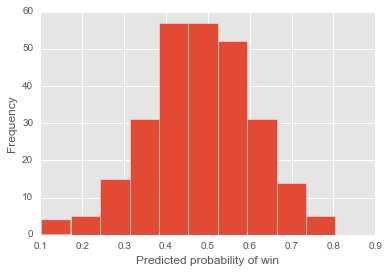

In [129]:
#fit first gen model

#Using all
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,40,41,42,43,44,45,46,47,
#                                                                    48,49,50,51,52,53,54,55,56,57,61]]

#using absolute variables only
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,40,41,42,43,44,45,46,47]]

#using difference variables only
#STANCE_DIFF doesn't add much value, but it makes the most sense
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57]]
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,66]]
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,62,64,65]]
feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[1,2,3,4,5,6,7,8,9,10,12]]

X = feature_cols
y = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].OUTCOME1

#split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#fit a logistic regression model and examine the coefficients
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#zip(feature_cols, logreg.coef_[0])

#make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

#Confusion Matrix
prds = logreg.predict(X)
print metrics.confusion_matrix(y_test, y_pred_class)

##Top Left: True Negatives 
##Top Right False Negatives 
##Bottom Left: False Negatives 
##Bottom Right: True Positives 


#predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of win')
plt.ylabel('Frequency')

#print the coeff
zip(feature_cols, logreg.coef_[0])

In [123]:
# convert log-odds to odds
print zip(feature_cols, np.exp(logreg.coef_[0]))

#Test case
print logreg.predict_proba([-3, 2, 2, 3, 3, 1,1,1,1, 1 ,1 ])[:, 1]
print logreg.predict_proba([+3, -2, -2, -3, -3, -1,-1,-1,-1, -1 ,0])[:, 1]

[('AGE_DIFF', 0.97593032366552468), ('HEIGHT_DIFF', 0.98935461776961464), ('WEIGHT_DIFF', 1.0010998618433147), ('EXP_DIFF', 1.0054284324150002), ('STRAVG_AT_FIGHT_DIFF', 1.0037634141476357), ('TDAVG_AT_FIGHT_DIFF', 1.0829860267913973), ('SUBAVG_AT_FIGHT_DIFF', 0.82678638713174002), ('PASSAVG_AT_FIGHT_DIFF', 1.0699031477334415), ('WINRATIO_DIFF', 1.6032695582255649), ('REACH_DIFF1', 1.0773861939875591), ('STANCE_DIFF1', 1.0403097394846144)]
[ 0.63881457]
[ 0.34537844]


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.57798165  0.55045872  0.59633028  0.50458716  0.59633028  0.66055046
  0.56481481  0.53703704  0.64485981  0.59813084]
0.583108103817
